# Unpaired image-to-image translation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from src.utils import get_files

Using TensorFlow backend.


## Import frames

In [2]:
base_dir = '/Users/jcboyd/Data/IncuCyte/ZG-MS-CD8T_cytotoxicity/'
experiment = 'raji_target'

train_files, val_files, test_files = get_files(base_dir, experiment)
all_files = train_files + val_files

to_export = []

for i in range(0, len(all_files), 110):  # jump over fields
    for j in range(0, 48, 12):  # jump one day at a time
        to_export.append(all_files[i + j])

pc_img = []

for file_name in to_export:
    pc_img.append(imread(os.path.join(base_dir, 'phase_contrast', file_name)))

No. train images: 1540
No. val images: 110
No. test images: 110


/Users/jcboyd/anaconda3/lib/python3.7/site-packages/skimage/external/tifffile/tifffile.py:2616: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [3]:
def preprocess_pc(img):

    return img / 255.

pc_img = [preprocess_pc(img) for img in pc_img]

## Extract crops

In [4]:
crop_size = 128

crops = []

for pc in pc_img:
    for y in range(0, pc.shape[0] - crop_size, crop_size):
        for x in range(0, pc.shape[1] - crop_size, crop_size):
            pc_crop = pc[y:y+crop_size, x:x+crop_size]
            crops.append(pc_crop)

crops = np.stack(crops)
x_train, x_test = crops[:1120], crops[1120:]

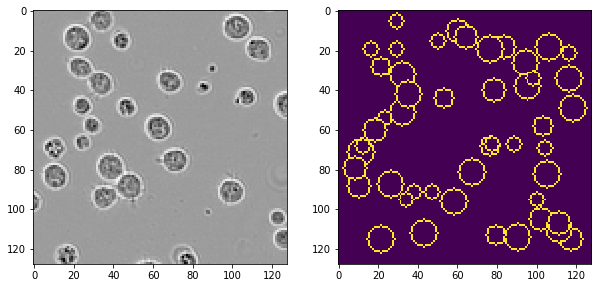

In [5]:
from src.style_transfer import draw_content

crop = 128

idx = np.random.randint(x_train.shape[0])
style_img = x_train[idx]

nb_cells = np.random.randint(10, 60)

content_img = draw_content(np.mean(x_train, axis=0), nb_cells=nb_cells)

fig, axes = plt.subplots(figsize=(10, 6), ncols=2)

axes[0].imshow(style_img, cmap='Greys_r')
axes[1].imshow(content_img)

## Train model

In [6]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from src.models import fnet_cycle, patch_gan_cycle
from src.utils import set_trainable

h, w, c = x_train.shape[1], x_train.shape[2], 1
img_shape = (h, w, c)

disc_patch = (h // 2 ** 4, w // 2 ** 4, c)

optimizer = Adam(0.0002, 0.5)

# Loss weights
lambda_cycle = 10.0               # Cycle-consistency loss
lambda_id = 0.1 * lambda_cycle    # Identity loss

# Build discriminators
d_A = patch_gan_cycle(img_shape)
d_B = patch_gan_cycle(img_shape)

d_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
d_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

# Build the generators
g_AB = fnet_cycle(img_shape, 32)
g_BA = fnet_cycle(img_shape, 32)

# Input images from both domains
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# Translate images to the other domain
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)

# Translate images back to original domain
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)

# Identity mapping of images
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# For the combined model we will only train the generators
set_trainable(d_A, False)
set_trainable(d_B, False)

# Discriminators determines validity of translated images
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

# Combined model trains generators to fool discriminators
combined = Model(inputs=[img_A, img_B], outputs=[valid_A, valid_B,
                                                 reconstr_A, reconstr_B,
                                                 img_A_id, img_B_id])

combined.compile(loss=['mse', 'mse',
                       'mae', 'mae',
                       'mae', 'mae'],
                 loss_weights=[1, 1,
                               lambda_cycle, lambda_cycle,
                               lambda_id, lambda_id],
                 optimizer=optimizer)

In [7]:
from src.utils import gen_cyclegan, sample_images

epochs = 200
batch_size = 1

# Adversarial loss ground truths
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

train_gen = gen_cyclegan(x_train)
steps_per_epoch = x_train.shape[0] // batch_size // 4

for epoch in range(epochs):

    for batch_i in range(steps_per_epoch):

        imgs_A, imgs_B = next(train_gen)

        # Translate images to opposite domain
        fake_B = g_AB.predict(imgs_A)
        fake_A = g_BA.predict(imgs_B)

        # Train the discriminators (original images = real / translated = Fake)

        set_trainable(d_A, True)
        set_trainable(d_B, True)

        dA_loss_real = d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = d_B.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        set_trainable(d_A, False)
        set_trainable(d_B, False)

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)

        # Train the generators
        g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, valid,
                                                            imgs_A, imgs_B,
                                                            imgs_A, imgs_B])

        # Plot the progress
        print('[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, rec: %05f, id: %05f]' \
              % (epoch, epochs, batch_i, steps_per_epoch, d_loss[0], 100 * d_loss[1], g_loss[0],
                  np.mean(g_loss[1:3]), np.mean(g_loss[3:5]), np.mean(g_loss[5:6])))

    # visualise progress
    sample_images(g_AB, g_BA, x_test, epoch)

    # save model weights
    g_AB.save_weights('./weights/g_ab_%d.h5' % epoch)
    g_BA.save_weights('./weights/g_ba_%d.h5' % epoch)
    d_A.save_weights('./weights/d_a_%d.h5' % epoch)
    d_B.save_weights('./weights/d_b_%d.h5' % epoch)

## Test model

In [8]:
g_AB = fnet_cycle(img_shape, 32)
g_AB.load_weights('./weights/g_ab_140.h5')

g_BA = fnet_cycle(img_shape, 32)
g_BA.load_weights('./weights/g_ba_140.h5')

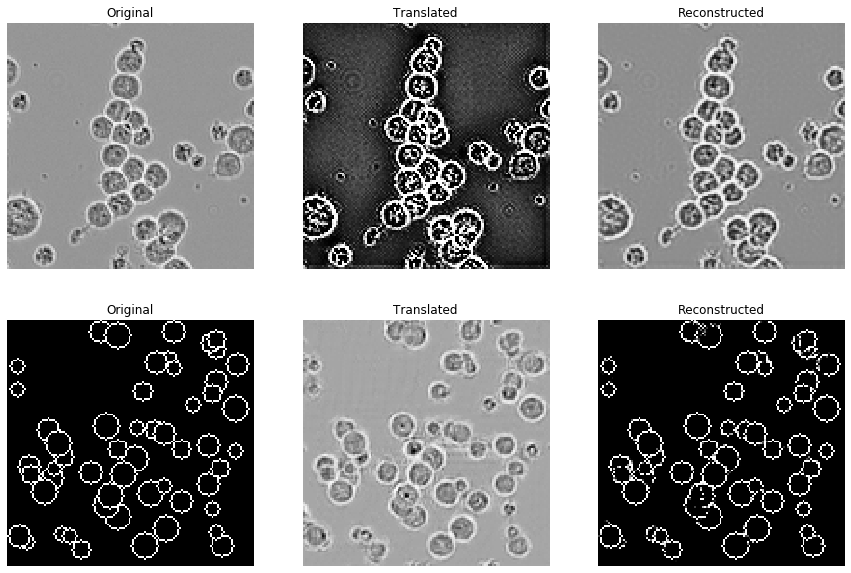

In [9]:
from src.utils import gen_cyclegan
from src.style_transfer import draw_content

gen_test = gen_cyclegan(x_test, batch_size=1)
imgs_A, imgs_B = next(gen_test)

# Translate images to the other domain
fake_B = g_AB.predict(imgs_A)
fake_A = g_BA.predict(imgs_B)

# Translate back to original domain
reconstr_A = g_BA.predict(fake_B)
reconstr_B = g_AB.predict(fake_A)

gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

# Rescale images
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=3)

cnt = 0

for i in range(2):

    for j in range(3):

        axs[i,j].imshow(gen_imgs[cnt].squeeze(), cmap='Greys_r')
        axs[i, j].set_title(titles[j])
        axs[i,j].axis('off')
        cnt += 1